# Stage 4a: Demonstrate using AI Alpha and Daily Betas to produce optiomal weights

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

# For Chromedriver
from pathlib import Path
chrome_executabel_path = str(Path.home()) + r'\Anaconda Projects\chromedriver\chromedriver'

# Make sure we have a data directory
Path('./data').mkdir(parents=True, exist_ok=True) 

masked_account_number = '#---9216'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

In [3]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


# Gather Data

- Current Holdings
- Price Histories
- AI Alpha
- Daily Beta

## First lets see why stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

In [4]:
# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest(username, password, client_id).get_quotes(utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
current_investments_df = equity_investments_df[equity_investments_df['symbol'].isin(current_stocks)]
current_investments_df

,account,shortQuantity,averagePrice,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,currentDayCost,previousSessionLongQuantity,assetType,cusip,symbol,description,type
6,#---9216,0.0,0.21531,-20.4975,-2.37,4500.0,4500.0,0.0,843.5,0.0,0.0,4500.0,EQUITY,Q3860H107,FGPHF,0,0


In [5]:
holdings = utils.read_port_data(portfolio_file_name).set_index('symbol')
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks from picing')

alpha_vectors = pd.read_csv('data/alpha_vectors.csv', parse_dates=['date']).set_index(['date']).sort_index()
print(f'You have {len(alpha_vectors.columns)} stocks from alpha')

with open('data/daily_beta.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
print(f'You have {len(daily_betas)} of daily betas')

Date range for price histories: 2016-07-20 to 2021-07-20
You have 500 stocks from picing
You have 500 stocks from alpha
You have 253 of daily betas


In [6]:
alpha_vectors[list(daily_betas.keys())[0]:]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL
date,,,,,,,,,,,,,,,,,,,,,
2020-07-20,-0.016949,-0.000008,0.016281,0.004182,-0.022003,-0.036854,0.018474,-0.016113,-0.035474,-0.028971,...,0.013644,-0.004704,0.001586,0.012678,-0.001369,-0.038236,-0.008905,-0.004707,0.010972,0.018750
2020-07-21,-0.015285,-0.001962,0.010389,0.003100,-0.022355,-0.037332,0.016180,-0.005648,-0.033036,-0.025475,...,0.013564,-0.000275,0.002656,0.017602,-0.002234,-0.036818,-0.016386,-0.003924,0.009436,0.018752
2020-07-22,-0.000130,-0.001922,0.008371,0.002494,-0.021739,-0.040547,0.015422,0.008928,-0.030558,-0.024939,...,0.013534,0.003700,0.008377,0.018204,-0.002299,-0.037657,-0.020911,-0.000641,0.007452,0.017943
2020-07-23,0.004712,-0.001928,0.008847,-0.007747,-0.018664,-0.041604,0.015476,0.010553,-0.034500,-0.029248,...,0.012988,0.005563,0.009086,0.017961,-0.002319,-0.037130,-0.022391,0.002810,0.005033,0.018311
2020-07-24,0.004876,-0.001673,0.010772,-0.005689,-0.019381,-0.040756,0.016287,0.006113,-0.035363,-0.027912,...,0.014499,0.005729,0.010260,0.017408,-0.004074,-0.025870,-0.021568,0.007445,0.003531,0.018403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-14,0.007196,0.009404,0.014772,-0.002461,-0.021739,-0.027044,-0.000068,-0.016549,-0.015140,0.006061,...,-0.008518,0.005337,-0.007591,-0.010221,0.016613,-0.008991,0.024506,-0.001109,-0.011014,-0.008998
2021-07-15,0.011974,0.015298,0.015698,0.004909,-0.016004,-0.026715,0.000775,-0.015047,-0.009025,0.007866,...,-0.012775,0.008085,-0.005884,-0.007740,0.016587,-0.004681,0.025435,-0.003047,-0.009465,-0.011239
2021-07-16,0.013246,0.015346,0.007487,0.011640,-0.015499,-0.027307,0.005747,-0.011881,-0.006492,0.008180,...,-0.012103,0.006899,-0.002758,-0.009210,0.010451,0.001303,0.017425,-0.003115,-0.008571,-0.017608


In [7]:
daily_betas.keys()

dict_keys(['07/20/2020', '07/21/2020', '07/22/2020', '07/23/2020', '07/24/2020', '07/27/2020', '07/28/2020', '07/29/2020', '07/30/2020', '07/31/2020', '08/03/2020', '08/04/2020', '08/05/2020', '08/06/2020', '08/07/2020', '08/10/2020', '08/11/2020', '08/12/2020', '08/13/2020', '08/14/2020', '08/17/2020', '08/18/2020', '08/19/2020', '08/20/2020', '08/21/2020', '08/24/2020', '08/25/2020', '08/26/2020', '08/27/2020', '08/28/2020', '08/31/2020', '09/01/2020', '09/02/2020', '09/03/2020', '09/04/2020', '09/08/2020', '09/09/2020', '09/10/2020', '09/11/2020', '09/14/2020', '09/15/2020', '09/16/2020', '09/17/2020', '09/18/2020', '09/21/2020', '09/22/2020', '09/23/2020', '09/24/2020', '09/25/2020', '09/28/2020', '09/29/2020', '09/30/2020', '10/01/2020', '10/02/2020', '10/05/2020', '10/06/2020', '10/07/2020', '10/08/2020', '10/09/2020', '10/12/2020', '10/13/2020', '10/14/2020', '10/15/2020', '10/16/2020', '10/19/2020', '10/20/2020', '10/21/2020', '10/22/2020', '10/23/2020', '10/26/2020', '10/27/20

## Generate Daily Optimal Portfolios using 1 year of alpha and beta

This first strategy is to use 2 day returns and optimize the portfolio daily.

The second stragety is to use last day of the month returns and to optimize the portfolio monthly (or 20 day returns).

Start with the last date, subtract 1 year to get the start and end dates for the betas.

In [8]:
import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

risk_cap = 0.10
weights_max = 0.33
weights_min = 0.0

<module 'portfolio_optimizer' from 'C:\\Users\\HP-Z440\\Anaconda Projects\\svi-trading-tools\\analysis-20210720\\../tools\\portfolio_optimizer.py'>

In [9]:
holding_weights = utils.get_portfolio_weights(holdings).squeeze()

In [10]:
returns = alpha_factors.FactorReturns(price_histories).factor_data

In [11]:
dlyreturn_n_days_delay = 2
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
delayed_returns.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL
date,,,,,,,,,,,,,,,,,,,,,
2020-07-21 00:00:00+00:00,0.003212,0.035456,-0.006918,-0.046585,0.003372,0.002117,-0.009124,0.006268,-0.008644,-0.030363,...,0.009665,0.025860,0.002203,0.011424,-0.029335,-0.001610,0.000388,0.002062,-0.002044,0.002550
2020-07-22 00:00:00+00:00,-0.019325,-0.032818,-0.007442,-0.002480,-0.009429,-0.002599,-0.005549,-0.018722,-0.003876,-0.003318,...,0.001988,0.002287,-0.011065,-0.011424,-0.006653,-0.005729,-0.004180,-0.006198,-0.016969,-0.004837
2020-07-23 00:00:00+00:00,0.025616,0.000000,-0.002992,0.023424,0.000515,0.002310,0.019171,0.010456,0.008454,0.015656,...,0.000000,0.016501,0.012384,0.051140,-0.037756,-0.005466,0.039629,0.014629,0.004845,0.013511
2020-07-24 00:00:00+00:00,-0.020461,0.032818,-0.004368,-0.016564,-0.004642,-0.018340,-0.012536,-0.001301,-0.005118,-0.011135,...,-0.024800,-0.010276,-0.012829,-0.008405,0.037211,0.012658,-0.018902,-0.011870,0.001150,-0.012300
2020-07-27 00:00:00+00:00,0.018712,-0.031941,0.013723,0.018987,0.003097,0.011684,0.014176,0.026289,0.009853,0.009303,...,0.026454,0.019929,0.072548,0.039574,0.025832,0.005252,0.028314,0.010962,0.029224,0.037362


In [12]:
opt_date = delayed_returns.index[0]
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
est_return = delayed_returns.loc[opt_date]

In [13]:
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

Old portfolio variance is:  nan
New portfolio variance is:  0.03442614


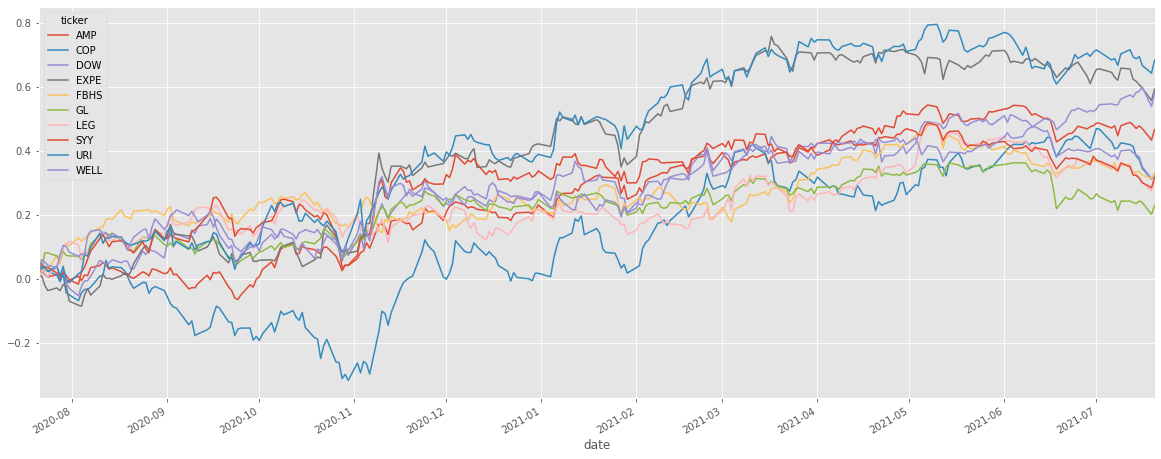

In [14]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
returns[-252:][long_weights.index.to_list()].cumsum().plot()
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(holding_weights.values):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [15]:
long_weights.index.to_list()

['AMP', 'COP', 'DOW', 'EXPE', 'FBHS', 'GL', 'LEG', 'SYY', 'URI', 'WELL']

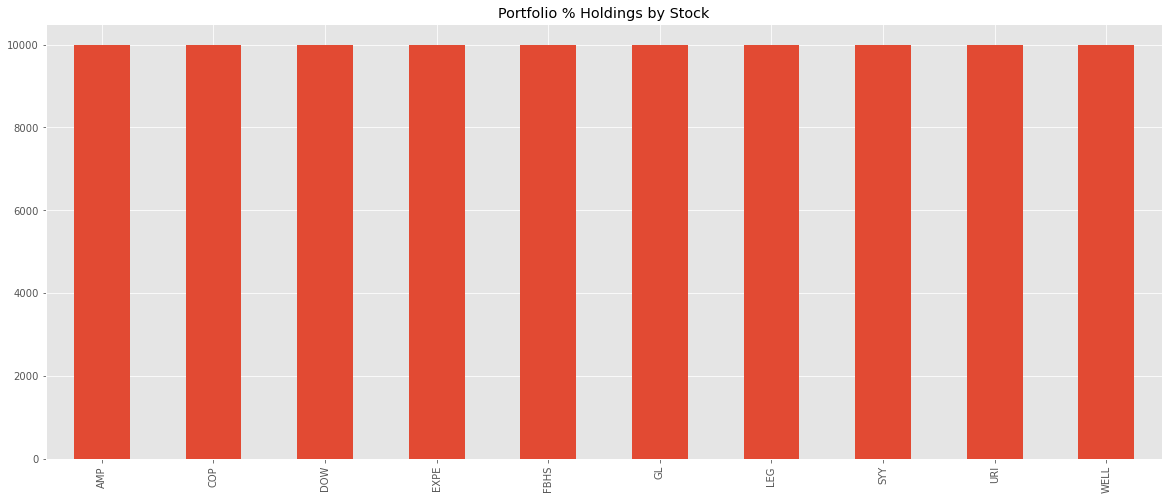

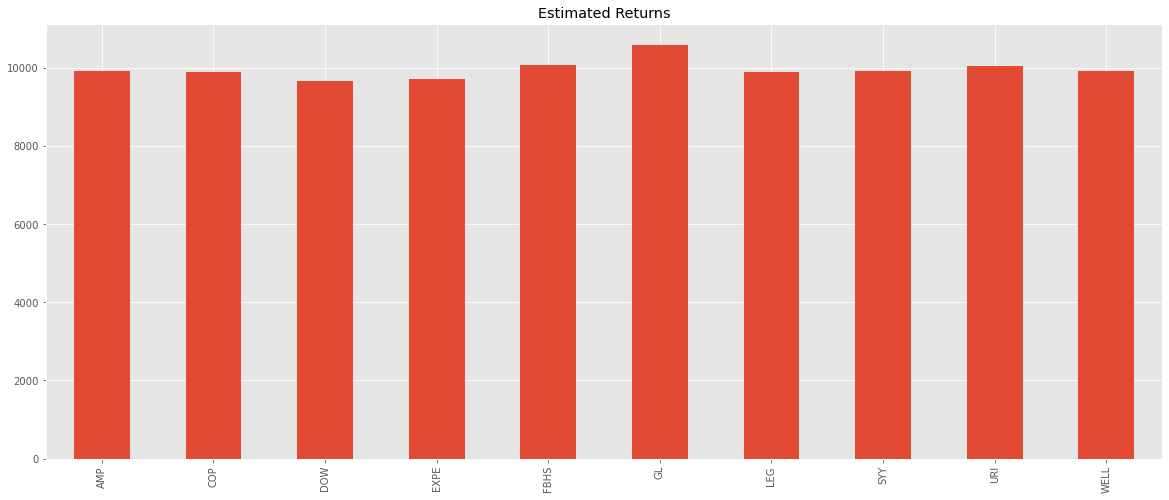

Original investment: 100000.0
New portfolio Value: 99647.02194352118


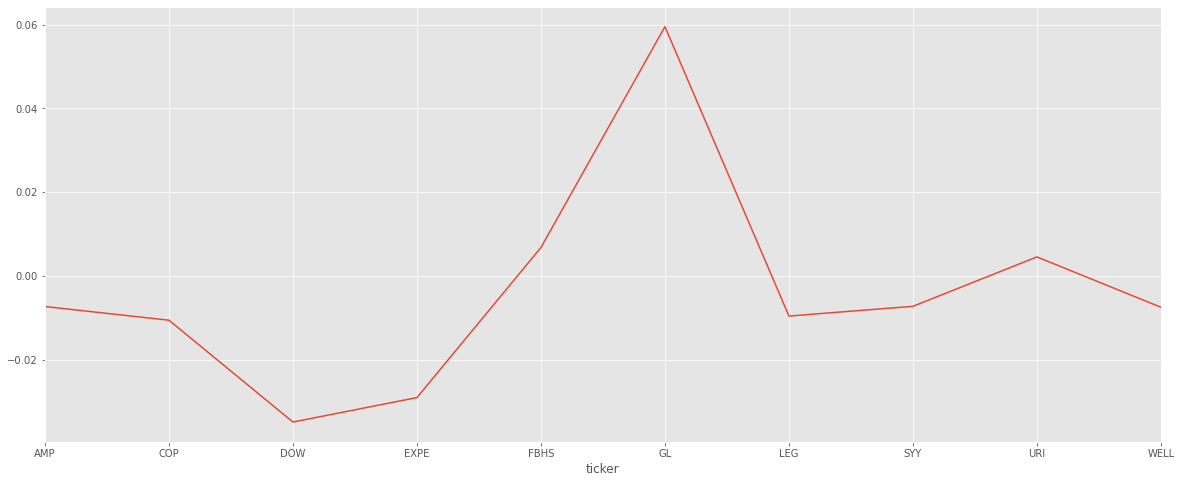

In [16]:
investment_amount = 100000
long_holdings = (long_weights['optimalWeights'] * investment_amount).round(0)
long_holdings.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
plt.show()
new_holdings = long_holdings * (1.0 + est_return[long_holdings.index])
new_holdings.plot.bar(legend=None, title='Estimated Returns')
plt.show()
print(f'Original investment: {long_holdings.sum()}')
print(f'New portfolio Value: {new_holdings.sum()}')
est_return[long_weights.index.to_list()].plot()

In [17]:
optimal_weights

,optimalWeights
A,-3.791047e-13
AAL,-8.230578e-14
AAP,2.963305e-13
AAPL,3.870179e-14
ABBV,-5.168789e-13
...,...
XEL,-7.860350e-13
XLNX,-4.009742e-13
XOM,-1.383223e-13
XRAY,2.536907e-13


In [18]:
np.zeros(len(delayed_returns.columns))

current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
current_holdings

,0
ticker,
A,0.0
AAL,0.0
AAP,0.0
AAPL,0.0
ABBV,0.0
...,...
XEL,0.0
XLNX,0.0
XOM,0.0


In [50]:
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list(), desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings

Generating 1 year Optimal Portfolios from 2020-07-21 00:00:00+00:00 to 2021-06-21 00:00:00+00:00


Dates:   0%|          | 0/232 [00:00<?, ?Portfolio Optimization/s]

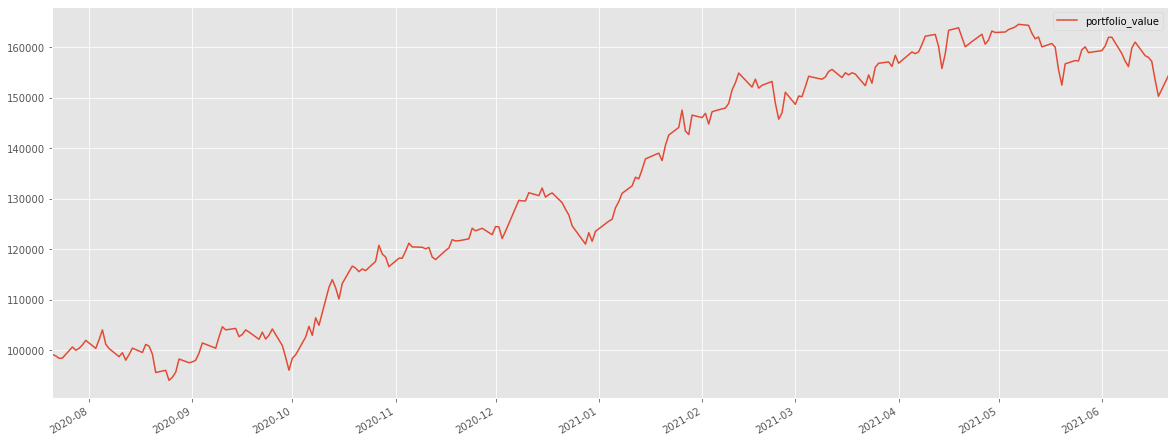

In [51]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

In [52]:
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings

Generating 1 year Optimal Portfolios from 2020-07-21 00:00:00+00:00 to 2021-06-21 00:00:00+00:00


Dates:   0%|          | 0/12 [00:00<?, ?Portfolio Optimization/s]

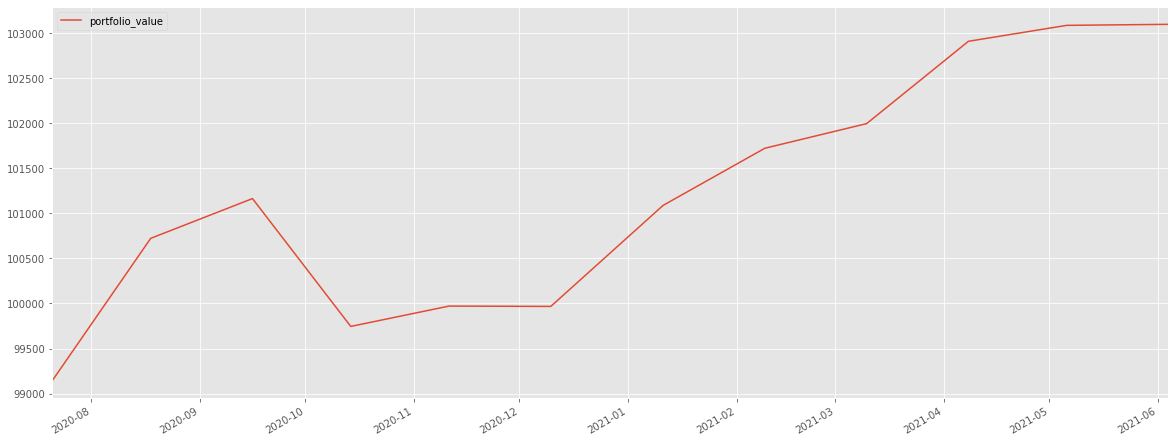

In [53]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

## 20 Day Strategy

Use 20 Day returns and optimize portfolio monthly

In [54]:
dlyreturn_n_days_delay = 20
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
delayed_returns.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL
date,,,,,,,,,,,,,,,,,,,,,
2020-07-21 00:00:00+00:00,0.003583,-0.001586,0.011425,0.008298,-0.007292,-0.005624,0.011722,0.002479,0.006897,0.026075,...,-0.022427,0.001163,-0.007541,-0.002766,-0.022650,-0.002853,-0.013663,-0.004937,-0.010124,0.001388
2020-07-22 00:00:00+00:00,0.001021,0.006329,-0.012606,0.001254,0.004694,-0.011049,0.003665,-0.004766,0.001706,-0.003241,...,0.005141,-0.001418,-0.003370,0.003111,-0.004543,-0.006018,-0.008074,-0.011139,-0.016791,0.000630
2020-07-23 00:00:00+00:00,-0.001839,-0.014297,-0.021179,0.021947,-0.009409,-0.026602,-0.013902,0.011380,0.008403,0.035028,...,-0.015851,0.001999,-0.014022,0.001035,-0.012133,-0.008226,-0.009913,-0.015370,-0.012305,0.000000
2020-07-24 00:00:00+00:00,0.005304,-0.027577,-0.008484,0.050249,-0.003578,-0.009027,-0.007902,0.007548,0.003712,-0.011054,...,-0.011529,-0.014590,0.005122,-0.006226,0.030787,0.008657,0.006097,-0.007531,0.014185,0.000252
2020-07-27 00:00:00+00:00,-0.007147,0.100083,0.006576,0.011889,-0.003696,-0.005927,-0.008555,-0.009912,0.001094,0.006488,...,0.094479,-0.006689,0.018140,0.013442,0.047184,0.011427,0.004597,0.029078,0.019757,0.024877


In [55]:
risk_cap = 0.04
weights_max = 0.075
weights_min = 0.0

In [56]:
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings

Generating 1 year Optimal Portfolios from 2020-07-21 00:00:00+00:00 to 2021-06-21 00:00:00+00:00


Dates:   0%|          | 0/12 [00:00<?, ?Portfolio Optimization/s]

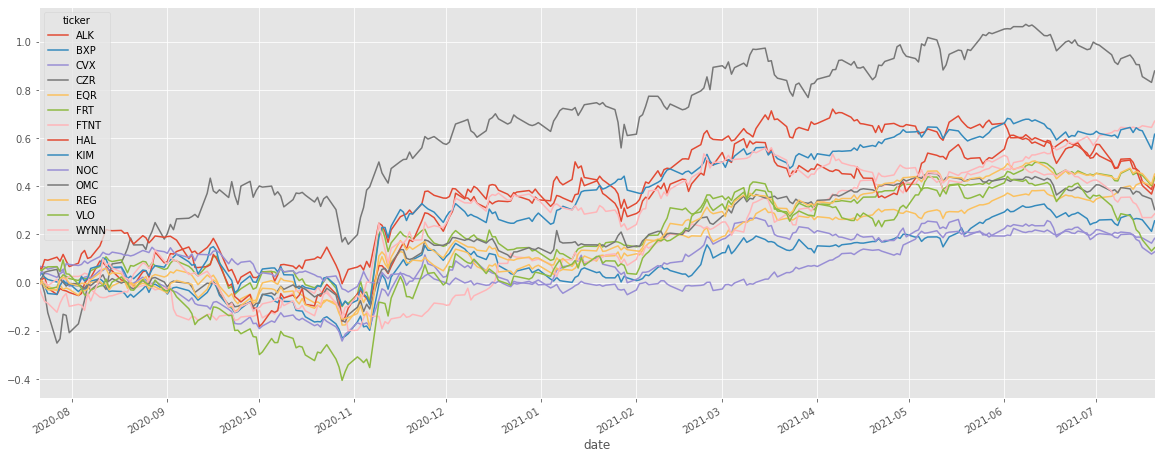

In [57]:
returns[-252:][long_weights.index.to_list()].cumsum().plot()

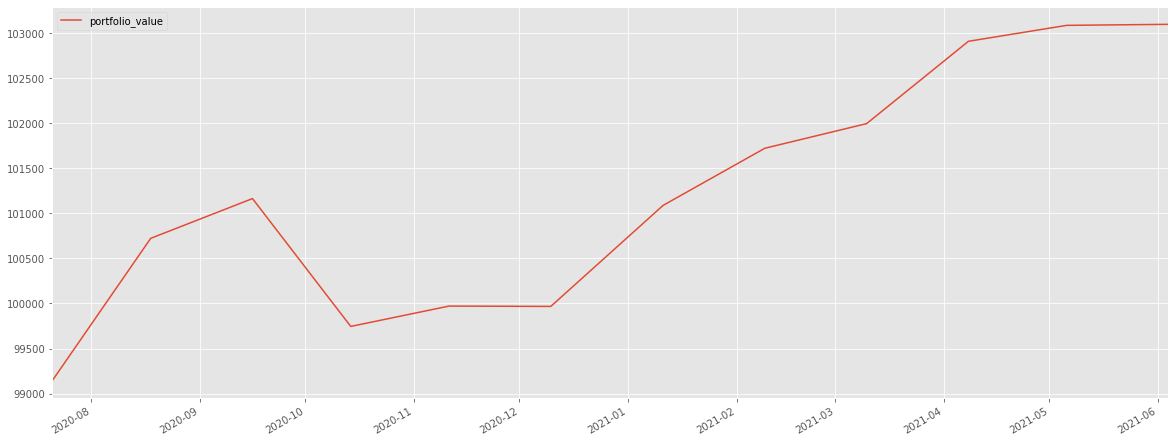

In [58]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

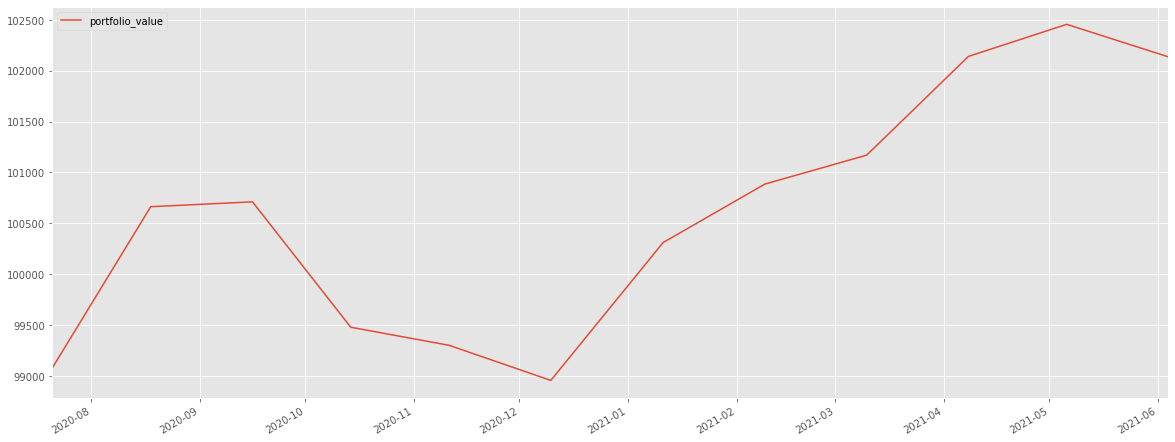

In [25]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

In [62]:
risk_cap = 0.04
weights_max = 0.125
weights_min = 0.0

In [63]:
opt_date = alpha_vectors.index[-1]
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

Old portfolio variance is:  nan
New portfolio variance is:  0.01390459


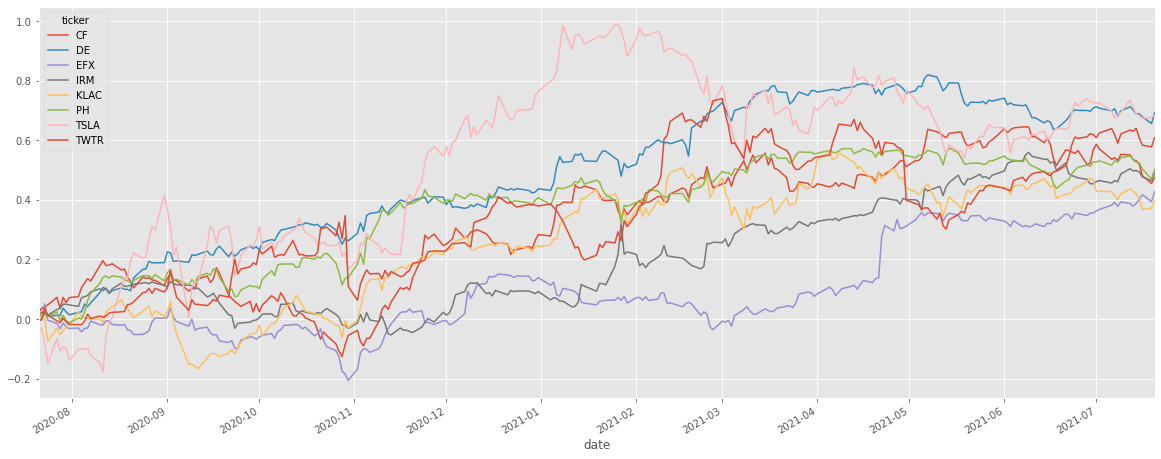

In [64]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
returns[-252:][long_weights.index.to_list()].cumsum().plot()
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(holding_weights.values):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [65]:
long_weights

,optimalWeights
CF,0.125
DE,0.125
EFX,0.125
IRM,0.125
KLAC,0.125
PH,0.125
TSLA,0.125
TWTR,0.125


In [70]:

long_quotes

,assetType,assetMainType,cusip,symbol,description,bidPrice,bidSize,bidId,askPrice,askSize,...,regularMarketLastPrice,regularMarketLastSize,regularMarketNetChange,regularMarketTradeTimeInLong,netPercentChangeInDouble,markChangeInDouble,markPercentChangeInDouble,regularMarketPercentChangeInDouble,delayed,realtimeEntitled
CF,EQUITY,EQUITY,125269100,CF,"CF Industries Holdings, Inc. Common Stock",47.66,300,T,47.72,100,...,47.660,1,0.710,1626875187700,1.5122,0.710,1.5122,1.5122,True,False
DE,EQUITY,EQUITY,244199105,DE,Deere & Company Common Stock,352.68,100,N,353.10,100,...,352.890,1,4.860,1626875183811,1.3964,4.860,1.3964,1.3964,True,False
EFX,EQUITY,EQUITY,294429105,EFX,"Equifax, Inc. Common Stock",256.53,100,U,257.04,200,...,256.930,1,0.350,1626875152086,0.1364,0.350,0.1364,0.1364,True,False
IRM,EQUITY,EQUITY,46284V101,IRM,Iron Mountain Incorporated (Delaware)Common St...,43.80,300,V,43.85,400,...,43.810,1,0.020,1626875135865,0.0457,0.020,0.0457,0.0457,True,False
KLAC,EQUITY,EQUITY,482480100,KLAC,KLA Corporation - Common Stock,309.41,300,P,309.83,100,...,309.705,1,6.935,1626875185235,2.2905,6.935,2.2905,2.2905,True,False
PH,EQUITY,EQUITY,701094104,PH,Parker-Hannifin Corporation Common Stock,306.66,100,N,307.11,100,...,306.810,1,7.280,1626875189678,2.4305,7.280,2.4305,2.4305,True,False
TSLA,EQUITY,EQUITY,88160R101,TSLA,"Tesla, Inc. - Common Stock",658.38,100,P,658.75,100,...,658.520,1,-1.980,1626875194062,-0.2998,-1.980,-0.2998,-0.2998,True,False
TWTR,EQUITY,EQUITY,90184L102,TWTR,"Twitter, Inc. Common Stock",68.08,100,N,68.10,200,...,68.090,6,0.150,1626875193620,0.2208,0.150,0.2208,0.2208,True,False


In [74]:
investment_amount = 5000

long_quotes = amc.AmeritradeRest(username, password, client_id).get_quotes(long_weights.index.to_list())
long_holdings = (long_weights['optimalWeights'] * investment_amount).round(0)
(long_holdings / long_quotes['bidPrice'])

CF      13.157895
DE       1.765636
EFX      2.434559
IRM     14.159493
KLAC     2.010487
PH       2.043151
TSLA     0.949430
TWTR     9.141436
dtype: float64

In [75]:
long_holdings

CF      625.0
DE      625.0
EFX     625.0
IRM     625.0
KLAC    625.0
PH      625.0
TSLA    625.0
TWTR    625.0
Name: optimalWeights, dtype: float64

# Alternative optimization option using trading costs

## Adjust dates to account for trade execution

returns represents the the returns that the optimized portfolio would realize, but only after we've received the data, then chosen the optimal holdings, and allowed a day to trade into the optimal holdings.  In other words, if we use the data from daily_betas and alpha_vectors that is collected at the end of Monday, we'll use portfolio optimization to choose the optimal holdings based on this data, perhaps after hours on Monday.  Then on Tuesday, we'll have a day to execute trades to adjust the portfolio into the optimized positions.  Then on Wednesday, we'll realize the returns using those optimal holdings.

In [26]:
risk_model.factor_returns_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2020-06-05 00:00:00+00:00,-0.840843,0.010765,-0.084019,-0.058235,0.132591,-0.060882,0.052210,0.010407,-0.111463,-0.058074,0.047105,0.042700,0.039205,-0.147383,0.036146,0.145112,0.030409,-0.025252,-0.016513,0.160253
2020-06-08 00:00:00+00:00,-0.566357,0.174042,-0.046161,0.023759,0.123321,-0.281198,0.043749,0.024941,-0.018870,-0.171427,0.004684,-0.094634,0.078993,-0.064009,-0.020664,-0.116380,0.041854,0.007062,-0.081489,-0.060507
2020-06-09 00:00:00+00:00,0.669551,-0.067934,-0.038749,-0.071789,0.053208,0.138335,-0.072535,0.054959,0.043592,0.014621,-0.112730,0.072992,-0.016088,0.006104,0.034805,0.039023,0.036839,0.030884,0.060549,0.012170
2020-06-10 00:00:00+00:00,0.705992,-0.248611,0.001499,-0.010476,0.085253,0.048330,-0.042630,0.007831,0.035247,0.117232,0.024054,-0.016177,-0.004651,-0.070615,0.043423,-0.019096,-0.051400,0.013308,0.016990,0.035282
2020-06-11 00:00:00+00:00,1.661110,0.372438,-0.149164,-0.019147,-0.029408,0.041215,-0.069446,-0.121447,-0.042673,0.039572,0.043932,0.066259,-0.036157,-0.000497,0.000590,-0.100940,0.044658,-0.061129,-0.020940,-0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28 00:00:00+00:00,0.047920,-0.028271,0.015662,0.001640,0.073842,0.052837,-0.013330,-0.025307,-0.001929,-0.002030,-0.015241,0.012115,0.010177,0.006753,0.025625,0.011414,0.019154,0.013587,0.005347,0.007653
2021-06-01 00:00:00+00:00,-0.175885,0.169289,-0.103423,-0.144212,0.067508,-0.051114,0.041724,0.016961,-0.039725,0.068217,-0.057807,0.019767,0.054388,0.000218,0.010459,-0.004268,0.013676,0.022949,0.038410,0.026065
2021-06-02 00:00:00+00:00,0.019263,0.017117,-0.030137,-0.029547,0.139988,-0.064827,-0.014349,0.026055,-0.022509,-0.054343,-0.031221,-0.004203,-0.012739,0.063729,-0.016423,0.054783,-0.018366,-0.019931,-0.014649,-0.010471


In [27]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

NameError: name 'portfun' is not defined

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)